In [1]:
# 移動平均の算出
# 重みなし

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import japanize_matplotlib

In [3]:
def root_mean_squared_error(y_pred, y_test):
    return mean_squared_error(y_pred, y_test)**(1/2)


In [4]:
df_raw = pd.read_csv("../data/kk.csv")
# 全体のみを利用(産地名NaN)
is_nan = [df_raw["産地名"][i] is df_raw["産地名"][0] for i in range(df_raw.shape[0])]
df = df_raw[is_nan].copy()
del_columns = ["産地名", "産地コード", "品目名", "品目コード", "対前日比（数量）", "対前日比（価格）"]
df = df.drop(del_columns, axis=1).copy()


In [5]:
# 曜日の処理
dow = ["月", "火", "水", "木", "金", "土", "日"]
df["曜日"] = [dow.index(dw) for dw in df["曜日"]]


In [6]:
# 日にちの処理
# timestamp型 → timedelta
date_columns = ["年", "月", "日"]
date = [str(df["年"].iloc[i])+"-"+str(df["月"].iloc[i])+"-" +
        str(df["日"].iloc[i]) for i in range(df.shape[0])]
df["date"] = pd.to_datetime(date)
df = df.drop(date_columns, axis=1).copy()
df["days"] = [(date - df["date"][0]).days for date in df["date"]]
df = df.drop("date", axis=1).copy()


In [7]:
# 特異日 (天皇即位)
outlier = df[df["価格"].max() == df["価格"]].index 
df = df.drop(outlier, axis=0).copy()

Text(0.5, 1.0, '7日移動平均')

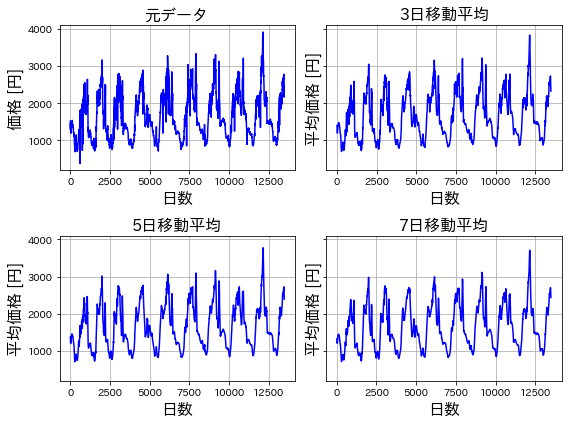

In [8]:
sma3 = df["価格"].rolling(3).mean()
sma5 = df["価格"].rolling(5).mean()
sma7 = df["価格"].rolling(7).mean()

fig, ax = plt.subplots(2, 2, tight_layout=True, sharey="all")
fig.set_figwidth(8)
fig.set_figheight(6)

ax[0, 0].grid()
ax[0, 0].plot(df["価格"].index, df["価格"].values, "b",
              label="simple moving average by 3 days")
ax[0, 0].set_xlabel("日数", fontsize=16)
ax[0, 0].set_ylabel("価格 [円]", fontsize=16)
ax[0, 0].set_title("元データ", fontsize=16)

ax[0, 1].grid()
ax[0, 1].plot(sma3.index, sma3.values, "b", label="simple moving average by 3 days")
ax[0, 1].set_xlabel("日数", fontsize=16)
ax[0, 1].set_ylabel("平均価格 [円]", fontsize=16)
ax[0, 1].set_title("3日移動平均", fontsize=16)

ax[1, 0].grid()
ax[1, 0].plot(sma5.index, sma5.values, "b",
              label="simple moving average by 5 days")
ax[1, 0].set_xlabel("日数", fontsize=16)
ax[1, 0].set_ylabel("平均価格 [円]", fontsize=16)
ax[1, 0].set_title("5日移動平均", fontsize=16)

ax[1, 1].grid()
ax[1, 1].plot(sma7.index, sma7.values, "b")
ax[1, 1].set_xlabel("日数", fontsize=16)
ax[1, 1].set_ylabel("平均価格 [円]", fontsize=16)
ax[1, 1].set_title("7日移動平均", fontsize=16)



In [9]:
# 数量で重み付け
def ma_weighted(price, df):
    """
    Args:
        price (df.rolling): df.rolling.apply()を想定した価格列
        df: 重み列を取るための元df
    return:
        ma_w = 数量加重移動平均
    """

    df_price = df.loc[price.index, '価格']
    df_num = df.loc[price.index, '数量']
    
    ma_w = 0
    for p, n in zip(df_price, df_num):
        ma_w += n * p/df_num.sum()

    return ma_w


In [10]:
df

,曜日,数量,価格,days
0,3,840793,1525,0
4,4,528012,1377,1
8,5,317676,1292,2
12,0,667,1466,4
15,1,549611,1234,5
...,...,...,...,...
13463,1,3786,2521,3561
13466,3,5602,2491,3563
13470,4,2980,2165,3564
13474,5,3349,2347,3565


In [11]:
# n_sum = 840793+528012+317676
# price = 840793/n_sum * 1525 + 528012/n_sum * 1377 + 317676/n_sum * 1292
# price

In [12]:
df["価格"].rolling(3).mean()

0                NaN
4                NaN
8        1398.000000
12       1378.333333
15       1330.666667
            ...     
13463    2536.666667
13466    2519.000000
13470    2392.333333
13474    2334.333333
13479    2327.000000
Name: 価格, Length: 2663, dtype: float64

Text(0, 0.5, 'average price [yen]')

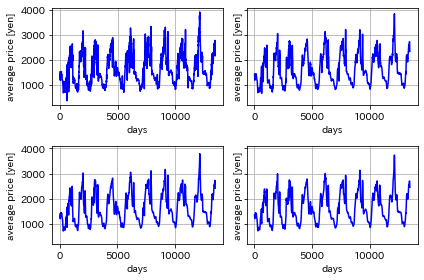

In [13]:
ma_w3 = df["価格"].rolling(3).apply(ma_weighted, args=(df,), raw=False)
ma_w5 = df["価格"].rolling(5).apply(ma_weighted, args=(df,), raw=False)
ma_w7 = df["価格"].rolling(7).apply(ma_weighted, args=(df,), raw=False)

fig, ax = plt.subplots(2, 2, tight_layout=True, sharey="all")
ax[0, 0].grid()
ax[0, 0].plot(df["価格"].index, df["価格"].values, "b",
              label="num-weighted moving average by 3 days")
ax[0, 0].set_xlabel("days")
ax[0, 0].set_ylabel("average price [yen]")

ax[0, 1].grid()
ax[0, 1].plot(ma_w3.index, ma_w3.values, "b",
              label="num-weighted moving average by 3 days")
ax[0, 1].set_xlabel("days")
ax[0, 1].set_ylabel("average price [yen]")

ax[1, 0].grid()
ax[1, 0].plot(ma_w5.index, ma_w5.values, "b",
              label="num-weighted moving average by 5 days")
ax[1, 0].set_xlabel("days")
ax[1, 0].set_ylabel("average price [yen]")

ax[1, 1].grid()
ax[1, 1].plot(ma_w7.index, ma_w7.values, "b",
              label="num-weighted moving average by 7 days")
ax[1, 1].set_xlabel("days")
ax[1, 1].set_ylabel("average price [yen]")


In [14]:
# 加重移動平均 (5日) で頑張る

In [15]:
# train-test-split
# 7年分をtrain，3年分をtest(index 9426以上)
ma_w5 = ma_w5.dropna()
df_train = ma_w5[ma_w5.index < 9426].copy()
df_test = ma_w5[ma_w5.index >= 9426].copy()


In [16]:
# SVMの場合
n_train = df_train.shape[0] - 7 - 6
X_train_idx = [np.array([0, 1, 2, 3, 4, 5, 6]) + i for i in range(n_train)]
y_train_idx = [i + 7 + 6 for i in range(n_train)]

n_test = df_test.shape[0] - 7 - 6
X_test_idx = [np.array([0, 1, 2, 3, 4, 5, 6]) + i for i in range(n_test)]
y_test_idx = [i + 7 + 6 for i in range(n_test)]

X_train = np.array([df_train.iloc[xt_i].values for xt_i in X_train_idx])
y_train = np.array([df_train.iloc[yt_i] for yt_i in y_train_idx])

X_test = np.array([df_test.iloc[xt_i].values for xt_i in X_test_idx])
y_test = np.array([df_test.iloc[yt_i] for yt_i in y_test_idx])

In [18]:
from sklearn.svm import SVR
model = SVR()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

score = root_mean_squared_error(y_pred, y_test)
print(score)

ape = sum(abs((y_test-y_pred)/y_test))
mape = ape/y_test.shape
print(mape[0])


416.4901052573621
0.14937711536610038


In [19]:
import lightgbm as lgb

model = lgb.LGBMRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

score = root_mean_squared_error(y_pred, y_test)
print(score)

ape = sum(abs((y_test-y_pred)/y_test))
mape = ape/y_test.shape[0]
print(mape)

214.6876515526596
0.07629306276852521


Text(0.5, 1.0, '市場価格5日移動平均の予測')

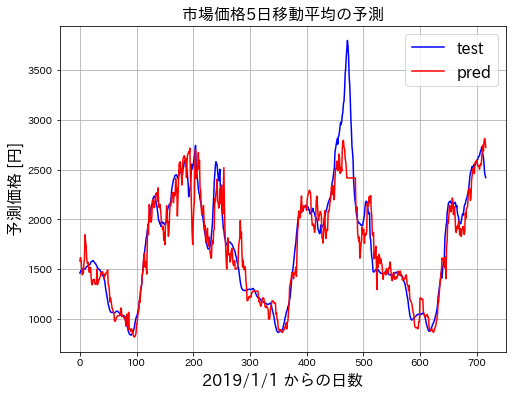

In [49]:
fig, ax = plt.subplots()
ax.grid()
fig.set_figwidth(8)
fig.set_figheight(6)

ax.plot(np.arange(y_test.shape[0]), y_test, "b", label="test")
ax.plot(np.arange(y_pred.shape[0]), y_pred, "r", label="pred")
ax.legend(fontsize=16)
ax.set_xlabel("2019/1/1 からの日数", fontsize=16)
ax.set_ylabel("予測価格 [円]", fontsize=16)
ax.set_title("市場価格5日移動平均の予測", fontsize=16)

# 差分をSVMで予測

In [20]:
price_temp = df["価格"].copy()
price_temp = price_temp.loc[ma_w5.index]
diff_ma_w5 = price_temp - ma_w5


In [21]:
diff_df = pd.concat([diff_ma_w5, df["days"].loc[diff_ma_w5.index]], axis=1)
diff_df = diff_df.set_index("days", drop=True).copy()

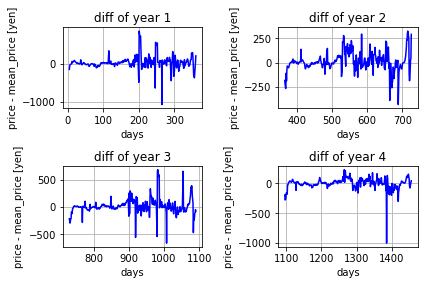

In [22]:
fig, ax = plt.subplots(2, 2, tight_layout=True)

a = 0
b = 365
ax[0, 0].grid()
ax[0, 0].plot(diff_df.loc[a:b].index, diff_df.loc[a:b], "b",
              label="year 1")
ax[0, 0].set_xlabel("days")
ax[0, 0].set_ylabel("price - mean_price [yen]")
ax[0, 0].set_title("diff of year 1")

a += 365
b+=365
ax[0, 1].grid()
ax[0, 1].plot(diff_df.loc[a:b].index, diff_df.loc[a:b], "b",
              label="year 2")
ax[0, 1].set_xlabel("days")
ax[0, 1].set_ylabel("price - mean_price [yen]")
ax[0, 1].set_title("diff of year 2")

a += 365
b += 365
ax[1, 0].grid()
ax[1, 0].plot(diff_df.loc[a:b].index, diff_df.loc[a:b], "b",
              label="year 3")
ax[1, 0].set_xlabel("days")
ax[1, 0].set_ylabel("price - mean_price [yen]")
ax[1, 0].set_title("diff of year 3")

a += 365
b += 365
ax[1, 1].grid()
ax[1, 1].plot(diff_df.loc[a:b].index, diff_df.loc[a:b], "b",
              label="year 4")
ax[1, 1].set_xlabel("days")
ax[1, 1].set_ylabel("price - mean_price [yen]")
ax[1, 1].set_title("diff of year 4")

plt.show()


平均からの誤差に周期性は見られない
比較的下半期の誤差が大きい？